In [2]:
from __future__ import print_function
from __future__ import division

import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import os
import time

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5,
                                          shuffle=True, num_workers=32)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=5,
                                         shuffle=False, num_workers=32)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

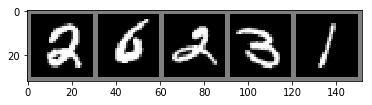

    2     6     2     3     1


In [4]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))

In [5]:
class CouplingFunction(nn.Module):
    """ The m coupling function form the paper
        A 5-layer NN with d inputs and D-d outputs
    """

    def __init__(self, in_d, out_d):
        super(CouplingFunction,self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_d, 1000),
            nn.LeakyReLU(0.2),
            nn.Linear(1000, 1000),
            nn.LeakyReLU(0.2),
            nn.Linear(1000, 1000),
            nn.LeakyReLU(0.2),
            nn.Linear(1000, 1000),
            nn.LeakyReLU(0.2),
            nn.Linear(1000, out_d),
        )
            
    def forward(self, x):
        return self.net(x)

In [6]:
m = CouplingFunction(300, 500)
m

CouplingFunction(
  (net): Sequential(
    (0): Linear(in_features=300, out_features=1000, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=1000, out_features=1000, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1000, out_features=1000, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=1000, out_features=500, bias=True)
  )
)

In [7]:
flattened_mnist = np.reshape(trainset.train_data,(trainset.train_data.shape[0], trainset.train_data.shape[1]*trainset.train_data.shape[2]))

In [8]:
flattened_batch = np.reshape(images, (images.shape[0], images.shape[1]*images.shape[2]*images.shape[3]))

In [9]:
dimensions = flattened_batch.shape[1]

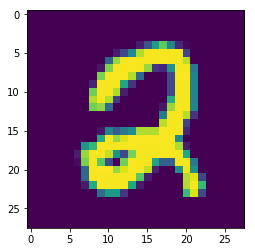

In [10]:
plt.imshow(flattened_batch[0].view(28,28))

In [13]:
split_point = flattened_batch.shape[1]//2
x1 = flattened_batch[:,:split_point]
x2 = flattened_batch[:,split_point:]

In [14]:
x2.shape

torch.Size([5, 392])

In [16]:
torch.cat((x1, x2),dim=1).shape

torch.Size([5, 784])

In [17]:
class AdditiveCouplingLayer(nn.Module):
    """
    Additive coupling layer from NICE paper
    y1 = x1
    y2 = x2 + m(x1)
    This version specifies a splitting point - d
    """
    
    def __init__(self, d, D, reverse = 0):
        """
        d is the dimension to use as a splitting point
        D is the total number of dimensions
        """
        super(AdditiveCouplingLayer, self).__init__()
        self.out = (D-d)
        self.input = d
        if reverse:
            self.out = d
            self.input = (D-d)
        self.m = CouplingFunction(self.input, self.out)
        self.reverse = reverse
        
    def forward(self, x):
        x1 = x[:,:self.input]
        x2 = x[:,self.input:]
        if self.reverse:
            x1 = x[:,self.input:]
            x2 = x[:,:self.input]
        y1 = x1
        y2 = x2 + self.m(x1)
        log_det = torch.zeros(x.shape[1])
        return torch.cat((y1, y2), dim=1), log_det
    
    def backward(self, y):
        y1 = y[:,:self.input]
        y2 = y[:,self.input:]
        if self.reverse:
            y2 = y[:,:self.input]
            y1 = y[:,self.input:]
        x1 = y1
        x2 = y2 - self.m(y1)
        log_det = torch.zeros(y.shape[1])
        return torch.cat((x1, x2), dim=1), log_det

In [18]:
class AdditiveCouplingLayerv2(nn.Module):
    """
    Additive coupling layer from NICE paper
    y1 = x1
    y2 = x2 + m(x1)
    This version splits the odd and even dimensions as mentioned in the paper.
    """
    
    def __init__(self, D, reverse = 0):
        super(AdditiveCouplingLayerv2, self).__init__()
        self.m = CouplingFunction(D//2, D//2)
        self.reverse = reverse
        
    def forward(self, x):
        x1 = x[:,::2]
        x2 = x[:,1::2]
        if self.reverse:
            x1 = x[:,1::2]
            x2 = x[:,::2]
        y1 = x1
        y2 = x2 + self.m(x1)
        log_det = torch.zeros(x.shape[1])
        return torch.cat((y1, y2), dim=1), log_det
    
    def backward(self, y):
        y1 = y[:,::2]
        y2 = y[:,1::2]
        if self.reverse:
            y1 = y[:,1::2]
            y2 = y[:,::2]
        x1 = y1
        x2 = y2 - self.m(y1)
        log_det = torch.zeros(y.shape[1])
        return torch.cat((x1, x2), dim=1), log_det

In [19]:
class Scale(nn.Module):
    """ 
    Scaling applied after the last additive coupling layer that allows the model to assign
    importances to different dimensions
    """
    def __init__(self, size):
        super(Scale, self).__init__()
        self.S = nn.Parameter(torch.randn(1, size, requires_grad=True))
        
    def forward(self, x):
        s = self.S
        z = x * torch.exp(s)
        log_det = torch.sum(s, dim=1)
        return z, log_det
    
    def backward(self, z):
        s = self.S
        x = z * torch.exp(-s)
        log_det = torch.sum(-s, dim=1)
        return x, log_det

In [144]:
from torch.distributions import Uniform, TransformedDistribution, MultivariateNormal
from torch.distributions.transforms import SigmoidTransform, AffineTransform

In [145]:
#Creating a logistic distribution
base_distribution = Uniform(torch.zeros(dimensions), torch.ones(dimensions))
transforms = [SigmoidTransform().inv, AffineTransform(loc=0, scale=1)]
logistic = TransformedDistribution(base_distribution, transforms)

#Creating a gaussian distribution
gaussian = MultivariateNormal(torch.zeros(dimensions), torch.eye(dimensions))

In [155]:
samples = logistic.sample([1000])

In [156]:
gs = gaussian.sample([1000])

In [157]:
gs.shape

torch.Size([1000, 784])

In [23]:
samples.shape

torch.Size([1000, 784])

In [24]:
torch.sum(torch.rand(1,24),dim=1).shape

torch.Size([1])

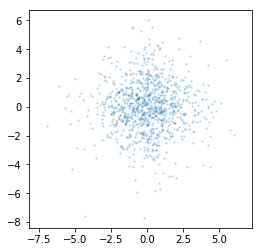

In [25]:
plt.figure(figsize=(4,4))
plt.scatter(samples[:,0], samples[:,1], s=2, alpha=0.2)
plt.axis('equal');

In [54]:
class NICE(nn.Module):
    """ Normalizing flow used in the NICE paper
        nl - number of additive layers
        sp - splitting point in the dimensional space
        nd - number of dimensions
    """

    def __init__(self, nl, sp, nd):
        super(NICE, self).__init__()
        layer_list = [AdditiveCouplingLayer(sp,nd,i%2) for i in range(nl)]
        layer_list.append(Scale(nd))
        self.full_layers = nn.ModuleList(layer_list)

    def forward(self, x):
        y = x
        #going through the layers
        for layer in self.full_layers:
            #it doesnt matter that we're overwritting the log-det since only the last one matters
            y, ld = layer.forward(y)
        return y, ld

    def backward(self, y):
        x = y
        #First do the scaling layer
        x, ld = self.full_layers[-1].backward(x)
        #going through the additive layers in reverse order
        for layer in self.full_layers[1::-1]:
            x, _ = layer.backward(x)
        return x, ld

In [169]:
#Model and optimizer 
model = NICE(5,dimensions//2,dimensions)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-4)

In [170]:
model

NICE(
  (full_layers): ModuleList(
    (0): AdditiveCouplingLayer(
      (m): CouplingFunction(
        (net): Sequential(
          (0): Linear(in_features=392, out_features=1000, bias=True)
          (1): LeakyReLU(negative_slope=0.2)
          (2): Linear(in_features=1000, out_features=1000, bias=True)
          (3): LeakyReLU(negative_slope=0.2)
          (4): Linear(in_features=1000, out_features=1000, bias=True)
          (5): LeakyReLU(negative_slope=0.2)
          (6): Linear(in_features=1000, out_features=1000, bias=True)
          (7): LeakyReLU(negative_slope=0.2)
          (8): Linear(in_features=1000, out_features=392, bias=True)
        )
      )
    )
    (1): AdditiveCouplingLayer(
      (m): CouplingFunction(
        (net): Sequential(
          (0): Linear(in_features=392, out_features=1000, bias=True)
          (1): LeakyReLU(negative_slope=0.2)
          (2): Linear(in_features=1000, out_features=1000, bias=True)
          (3): LeakyReLU(negative_slope=0.2)
        

batch: 0 loss: 16755.3007812
Sampling


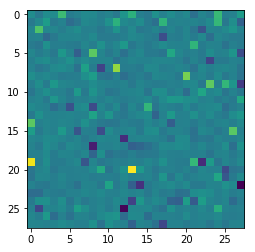

batch: 500 loss: 4568.42578125
Sampling


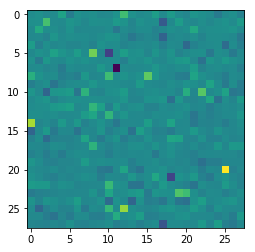

batch: 1000 loss: 4018.03979492
Sampling


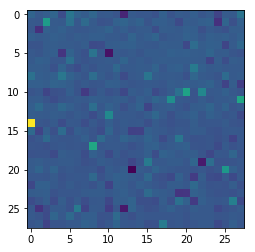

batch: 1500 loss: 4446.96240234
Sampling


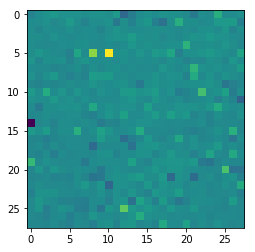

batch: 2000 loss: 3593.22143555
Sampling


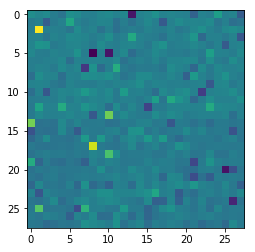

batch: 2500 loss: 3382.85375977
Sampling


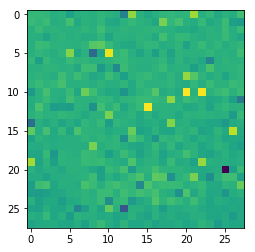

batch: 3000 loss: 3305.26391602
Sampling


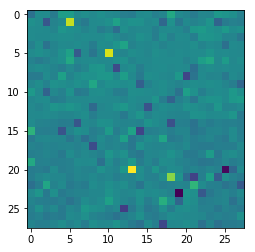

batch: 3500 loss: 2963.30859375
Sampling


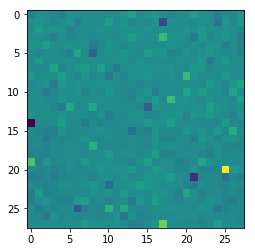

batch: 4000 loss: 2833.28588867
Sampling


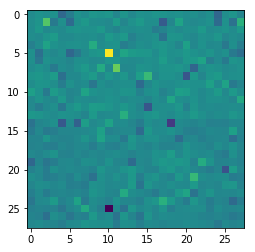

batch: 4500 loss: 2730.95776367
Sampling


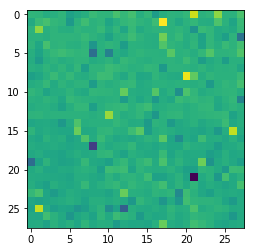

batch: 5000 loss: 2663.3737793
Sampling


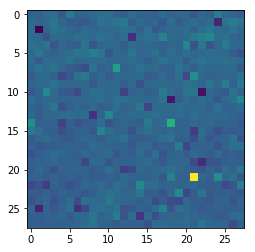

batch: 5500 loss: 2467.05932617
Sampling


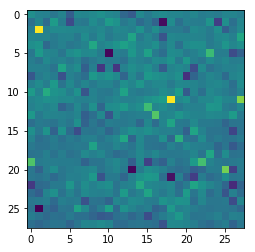

batch: 6000 loss: 2347.29003906
Sampling


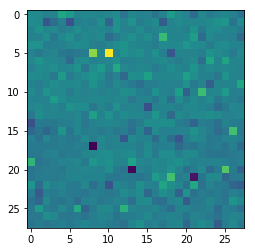

batch: 6500 loss: 2050.57836914
Sampling


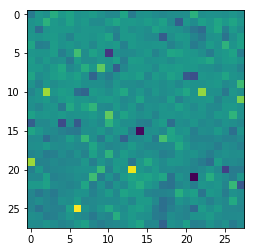

batch: 7000 loss: 2001.76464844
Sampling


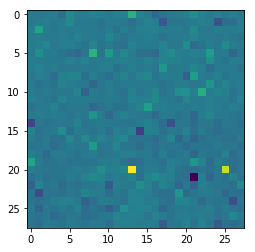

batch: 7500 loss: 1840.01293945
Sampling


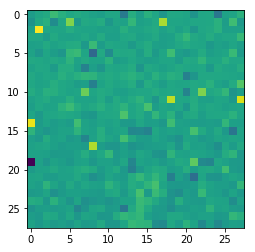

batch: 8000 loss: 1868.5090332
Sampling


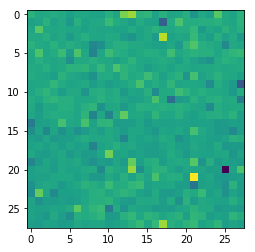

batch: 8500 loss: 1509.38305664
Sampling


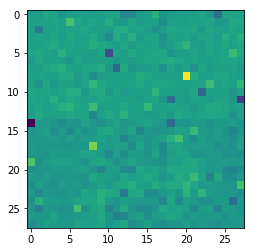

batch: 9000 loss: 1422.60351562
Sampling


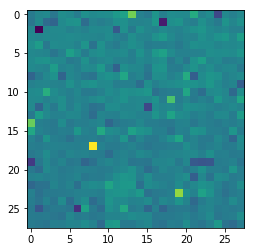

batch: 9500 loss: 1127.66821289
Sampling


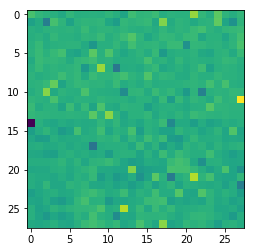

batch: 10000 loss: 1301.57250977
Sampling


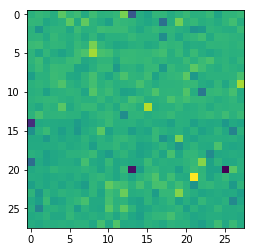

batch: 10500 loss: 815.198364258
Sampling


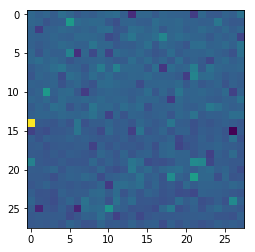

batch: 11000 loss: 1012.08276367
Sampling


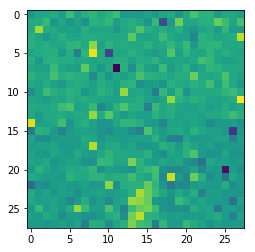

batch: 11500 loss: 779.852966309
Sampling


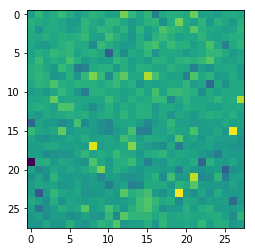

In [171]:
prior = gaussian
model.train()
losses = []
for epoch in range(1):
    dataiter = iter(trainloader)
    for batch in range(len(dataiter)):
    #for batch in range(1001):
        #print("batch:",batch)
        images, _ = dataiter.next()
        flattened_batch = np.reshape(images, (images.shape[0], images.shape[1]*images.shape[2]*images.shape[3]))
        y, log_det = model.forward(flattened_batch)
        
        #avoiding inf values in logprob with logistic #FIXME
        #y[y > 16.5] = 16
        #y[y < -88] = -88
        #########################
        prior_logprob = prior.log_prob(y)
        if prior is logistic:
            prior_logprob = prior_logprob.sum(1)    
        loss = -torch.sum(prior_logprob + log_det)
        losses.append(loss.item())
        
        if loss == float("inf"):
            print(y)
            print(prior.log_prob(y))
            print(prior_logprob)
            print(log_det)
        model.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 500 == 0:
            #losses.append(loss.item())
            print("batch:",batch,"loss:",loss.item())
            print("Sampling")
            h = prior.sample((1,))
            xs, _ = model.backward(h)
            plt.imshow(xs.detach().view(28,28))
            plt.show()

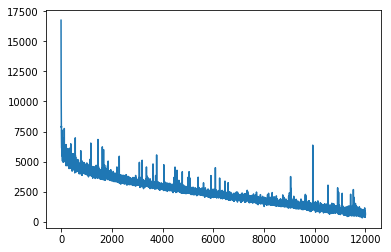

In [172]:
plt.plot(losses)
plt.show()